In [1]:
from __future__ import print_function
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets, transforms 

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
train = datasets.MNIST("./data", train =True, download =True, transform= train_transforms)
test = datasets.MNIST("./data", train =False , download =True, transform= test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=8, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [5]:
dropout_value = 0.1
from model import Model_2
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_2().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9            [-1, 6, 24, 24]              60
        MaxPool2d-10            [-1, 6, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]             648
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
          Dropout-14           [-1

In [6]:
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [7]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss+=loss.item()
        
        loss.backward()
        optimizer.step()
        correct += GetCorrectPredCount(output, target)
        processed += len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))
    
    print('\nTrain set: Train loss: {:.4f}, Train Accuracy: {}/{} ({:.2f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [8]:
from torch.optim.lr_scheduler import StepLR
model = Model_2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size =6, gamma =0.2)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


loss=0.13237044215202332 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 67.66it/s]



Train set: Train loss: 217.6045, Train Accuracy: 52694/60000 (87.82%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0672, Accuracy: 9809/10000 (98.09%)

EPOCH: 1


loss=0.07465716451406479 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 68.46it/s]



Train set: Train loss: 44.1556, Train Accuracy: 58412/60000 (97.35%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9868/10000 (98.68%)

EPOCH: 2


loss=0.08664918690919876 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 68.30it/s]



Train set: Train loss: 34.4827, Train Accuracy: 58720/60000 (97.87%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


loss=0.01864829659461975 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 68.12it/s]



Train set: Train loss: 28.9485, Train Accuracy: 58897/60000 (98.16%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9898/10000 (98.98%)

EPOCH: 4


loss=0.08975747227668762 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 69.72it/s]



Train set: Train loss: 26.4049, Train Accuracy: 58963/60000 (98.27%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


loss=0.15627223253250122 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 68.89it/s]



Train set: Train loss: 24.6104, Train Accuracy: 59008/60000 (98.35%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


loss=0.023396549746394157 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 68.92it/s]



Train set: Train loss: 19.7491, Train Accuracy: 59233/60000 (98.72%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

EPOCH: 7


loss=0.01528871152549982 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 68.00it/s]



Train set: Train loss: 19.0464, Train Accuracy: 59259/60000 (98.77%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9942/10000 (99.42%)

EPOCH: 8


loss=0.029128454625606537 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 69.05it/s]



Train set: Train loss: 18.6928, Train Accuracy: 59261/60000 (98.77%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

EPOCH: 9


loss=0.043312739580869675 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 68.29it/s]



Train set: Train loss: 18.1563, Train Accuracy: 59286/60000 (98.81%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)

EPOCH: 10


loss=0.08802318572998047 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 69.55it/s]



Train set: Train loss: 17.3674, Train Accuracy: 59312/60000 (98.85%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

EPOCH: 11


loss=0.030089491978287697 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 68.86it/s]



Train set: Train loss: 17.6414, Train Accuracy: 59300/60000 (98.83%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


loss=0.07300524413585663 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 69.65it/s]



Train set: Train loss: 17.0165, Train Accuracy: 59317/60000 (98.86%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


loss=0.025476574897766113 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 67.94it/s]



Train set: Train loss: 17.1701, Train Accuracy: 59314/60000 (98.86%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9947/10000 (99.47%)

EPOCH: 14


loss=0.010432176291942596 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 69.78it/s]



Train set: Train loss: 17.1694, Train Accuracy: 59342/60000 (98.90%)


Test set: Average loss: 0.0196, Accuracy: 9945/10000 (99.45%)



In [9]:
#t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

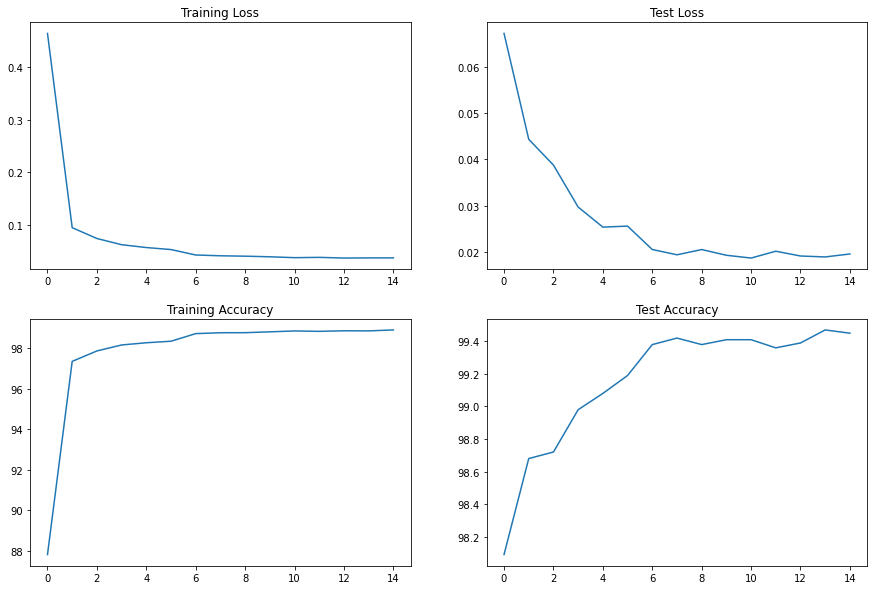

In [10]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Text(0.5, 1.0, 'Loss per epoch')

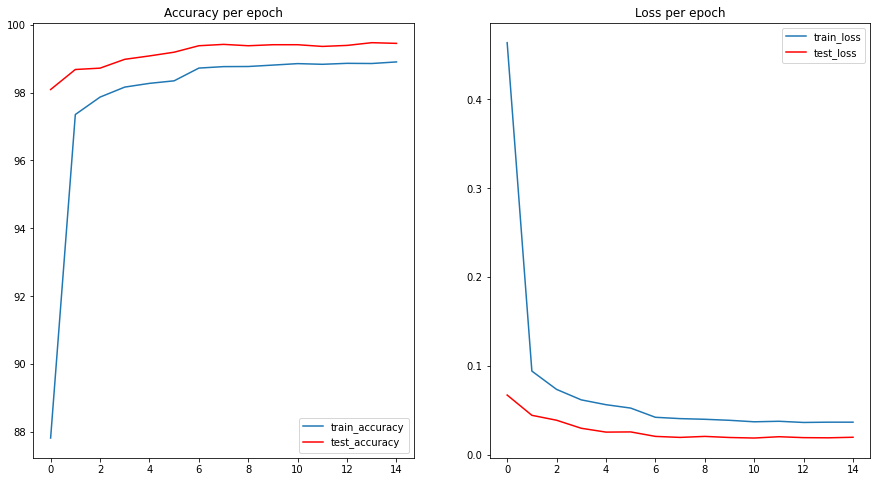

In [11]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 8]

plt.subplot(1,2, 1)

plt.plot(np.array(train_acc))
plt.plot(np.array(test_acc), 'r')
plt.legend(["train_accuracy", "test_accuracy"])
plt.title("Accuracy per epoch")

plt.subplot(1,2,2)
plt.plot(train_losses)
plt.plot(test_losses, 'r')
plt.legend(["train_loss", "test_loss"])
plt.title("Loss per epoch")
     

## Inference 

### Target 
1. Get set up
   Get transforms, Data Loader, Basic Working codd, training and test lopp 
   added the sheduler to change the learning rate ;  step_wise: 6; gamma: 0.2
2. Results 
   Parameters : 8.5 k Parameters  
   Epoch 15
   TRaining Acc: 98.91 
   Test Acc: 99.45
   
3. Analysis 
   1. small  model 
   2. no overfit model 
   3. 10th epoch reached 99.40 
   
